In [42]:
import depthai as dai
import numpy as np
import sys
from pathlib import Path
import cv2
from datetime import timedelta
import matplotlib.pyplot as plt
import cv2.aruco as aruco

# Importation des données de la caméra

In [43]:
calibFile = "calib.json"
calibData = dai.CalibrationHandler(calibFile)

mtx_inta_rgb = np.array(
    calibData.getCameraIntrinsics(dai.CameraBoardSocket.CAM_A, 1920, 1080)
)

dist_rgb = np.array(calibData.getDistortionCoefficients(dai.CameraBoardSocket.CAM_A))

mtx_extra_right = np.array(
    calibData.getCameraExtrinsics(dai.CameraBoardSocket.CAM_A, dai.CameraBoardSocket.CAM_C)
)

mtx_intra_right = np.array(
    calibData.getCameraIntrinsics(dai.CameraBoardSocket.CAM_C, 640, 480)
)

mtx_intra_left = np.array(
    calibData.getCameraIntrinsics(dai.CameraBoardSocket.CAM_B, 640, 480)
)

mtx_extra_left = np.array(
    calibData.getCameraExtrinsics(dai.CameraBoardSocket.CAM_A, dai.CameraBoardSocket.CAM_B)
)

print("#### RGB ####")
print("intrinsic matrix", mtx_inta_rgb)
print("distortion coefficients", dist_rgb)
print("#### RIGHT ####")
print("extrinsic matrix", mtx_extra_right)
print("intrinsic matrix", mtx_intra_right)
print("#### LEFT ####")
print("extrinsic matrix", mtx_extra_left)
print("intrinsic matrix", mtx_intra_left)

size_of_marker = 0.05
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_1000)
detector_parameters = aruco.DetectorParameters_create()

#### RGB ####
intrinsic matrix [[1.50046753e+03 0.00000000e+00 9.90489319e+02]
 [0.00000000e+00 1.50057544e+03 5.34727478e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distortion coefficients [-2.42180514e+00 -4.76292801e+00  5.88700932e-04 -2.64181173e-04
  2.91902065e+01 -2.52610898e+00 -4.30663729e+00  2.84569664e+01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
#### RIGHT ####
extrinsic matrix [[ 0.99990803  0.01079796  0.00820862 -3.75881124]
 [-0.01067881  0.99983895 -0.01442319 -0.0685038 ]
 [-0.00836303  0.0143342   0.99986231  0.16316929]
 [ 0.          0.          0.          1.        ]]
intrinsic matrix [[457.37179565   0.         309.44451904]
 [  0.         457.40008545 239.31492615]
 [  0.           0.           1.        ]]
#### LEFT ####
extrinsic matrix [[ 9.99100089e-01  2.15164125e-02 -3.65534537e-02  3.69256425e+00]
 [-2.24999953e-02  9.99389887e-01 -2.67132409e-02 -3.62900551e-03]
 [ 3.59563828e-02  2.75

In [44]:
def detect_markers(frame, dist, mtx, aruco_dict, detector_parameters, size_of_marker):

    frame_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    corners, ids, rejectedImgPoints = aruco.detectMarkers(
        frame_gray, aruco_dict, parameters=detector_parameters
    )

    rvecs, tvecs, trash = aruco.estimatePoseSingleMarkers(
        corners, size_of_marker, mtx, dist
    )

    if ids is not None:
        return corners, ids, rvecs, tvecs
    else:
        return None, None, None, None


def draw_markers(frame, corners, ids, rvecs, tvecs, mtx, dist):
    if ids is not None:
        frame_marker = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
        for rvec, tvec in zip(rvecs, tvecs):
            if tvec is not None:
                for i in range(len(tvec)):
                    frame_marker = aruco.drawAxis(
                        frame_marker, mtx, dist, rvec[i], tvec[i], 0.05
                    )
        if frame_marker is not None:
            return frame_marker
        else:
            return frame
    else:
        return frame

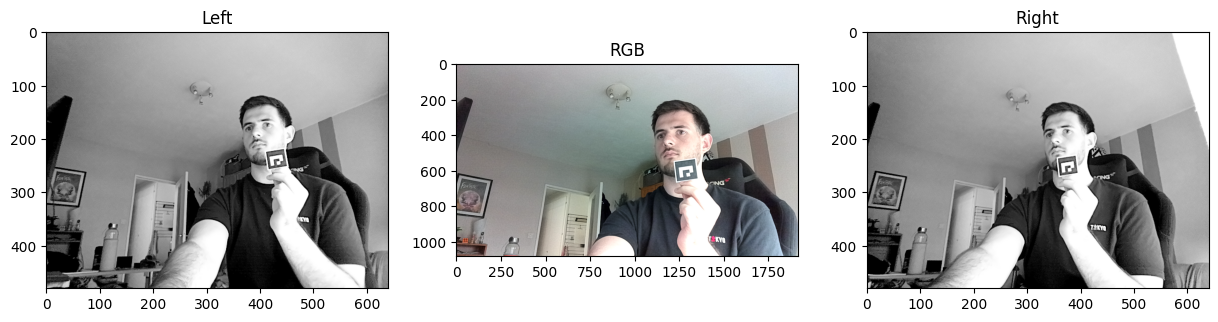

In [45]:
frame_rgb = cv2.imread("img/matching/rgb.png")
frame_left = cv2.imread("img/matching/left.png")
frame_right = cv2.imread("img/matching/right.png")

# show the 3 images in the same window with the title
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(frame_left)
plt.title("Left")
plt.subplot(132)
plt.imshow(cv2.cvtColor(frame_rgb, cv2.COLOR_BGR2RGB))
plt.title("RGB")
plt.subplot(133)
plt.imshow(frame_right)
plt.title("Right")
plt.show()

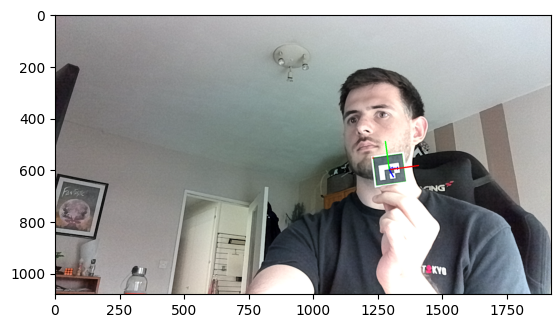

In [46]:
(corners, ids, rvecs, tvecs) = detect_markers(
    frame_rgb, dist_rgb, mtx_inta_rgb, aruco_dict, detector_parameters, size_of_marker
)

frame_rgb = draw_markers(frame_rgb, corners, ids, rvecs, tvecs, mtx_inta_rgb, dist_rgb)

plt.imshow(cv2.cvtColor(frame_rgb, cv2.COLOR_BGR2RGB))

In [47]:
P_coord = tvecs[0][0]
P_coord_homogene = np.array([P_coord[0], P_coord[1], P_coord[2], 1.0])
print(f"3D coordinates of the marker: {P_coord} in meters")
print(f"3D coordinates homogeneous of the marker: {P_coord_homogene} in meters")
print(f"3D coordinates of the marker: {P_coord*100} in centimeters")

3D coordinates of the marker: [0.13509892 0.02925853 0.67728864] in meters
3D coordinates homogeneous of the marker: [0.13509892 0.02925853 0.67728864 1.        ] in meters
3D coordinates of the marker: [13.50989212  2.92585267 67.72886392] in centimeters


2D coordinates of the marker: [1.28978792e+03 5.99551578e+02 1.00000000e+00] in pixels


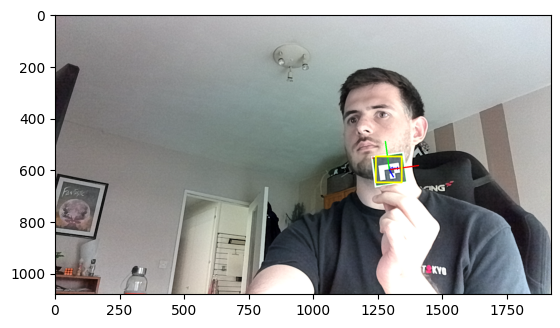

In [48]:
p_coord = np.dot(mtx_inta_rgb, P_coord)
p_coord = p_coord / p_coord[2]
print(f"2D coordinates of the marker: {p_coord} in pixels")

cv2.rectangle(
    frame_rgb,
    (int(p_coord[0]) - 50, int(p_coord[1]) - 50),
    (int(p_coord[0]) + 50, int(p_coord[1]) + 50),
    (0, 255, 255),
    5,
)

plt.imshow(cv2.cvtColor(frame_rgb, cv2.COLOR_BGR2RGB))

In [49]:
t_rgb_right = mtx_extra_right[:3, 3]/100
r_rgb_right = mtx_extra_right[:3, :3]

print(t_rgb_right)
print(r_rgb_right)

P_coord_right = np.dot(r_rgb_right, P_coord) + t_rgb_right

print(P_coord_right)

print(f"3D coordinates of the marker in the right camera: {P_coord_right} in meters")

p_coord_right = np.dot(mtx_intra_right, P_coord_right)

p_coord_right = p_coord_right / p_coord_right[2]

print(f"2D coordinates of the marker in the right camera: {p_coord_right} in pixels")

[-0.03758811 -0.00068504  0.00163169]
[[ 0.99990803  0.01079796  0.00820862]
 [-0.01067881  0.99983895 -0.01442319]
 [-0.00836303  0.0143342   0.99986231]]
[0.10337392 0.01735742 0.67811664]
3D coordinates of the marker in the right camera: [0.10337392 0.01735742 0.67811664] in meters
2D coordinates of the marker in the right camera: [379.1675017  251.02277313   1.        ] in pixels


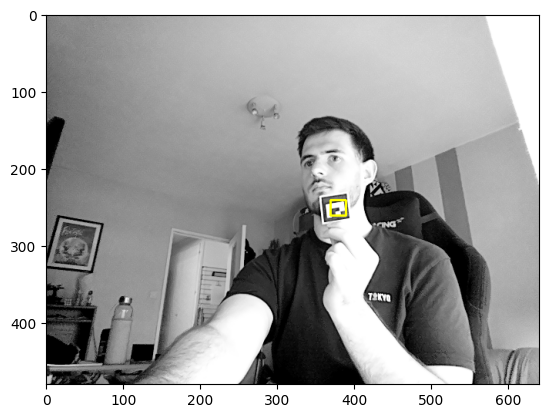

In [50]:
cv2.rectangle(
    frame_right,
    (int(p_coord_right[0]) - 10, int(p_coord_right[1]) - 10),
    (int(p_coord_right[0]) + 10, int(p_coord_right[1]) + 10),
    (0, 255, 255),
    2,
)

plt.imshow(cv2.cvtColor(frame_right, cv2.COLOR_BGR2RGB))

In [51]:
t_rgb_left = mtx_extra_left[:3, 3]/100
r_rgb_left = mtx_extra_left[:3, :3]

print(t_rgb_left)
print(r_rgb_left)

P_coord_left = np.dot(r_rgb_left, P_coord) + t_rgb_left

print(P_coord_left)

print(f"3D coordinates of the marker in the left camera: {P_coord_left} in meters")

p_coord_left = np.dot(mtx_intra_left, P_coord_left)

p_coord_left = p_coord_left / p_coord_left[2]

print(f"2D coordinates of the marker in the left camera: {p_coord_left} in pixels")

[ 3.69256425e-02 -3.62900551e-05  2.75532603e-03]
[[ 0.99910009  0.02151641 -0.03655345]
 [-0.0225      0.99938989 -0.02671324]
 [ 0.03595638  0.02751165  0.99897462]]
[0.14777529 0.00807209 0.68501211]
3D coordinates of the marker in the left camera: [0.14777529 0.00807209 0.68501211] in meters
2D coordinates of the marker in the left camera: [426.82864248 238.41267582   1.        ] in pixels


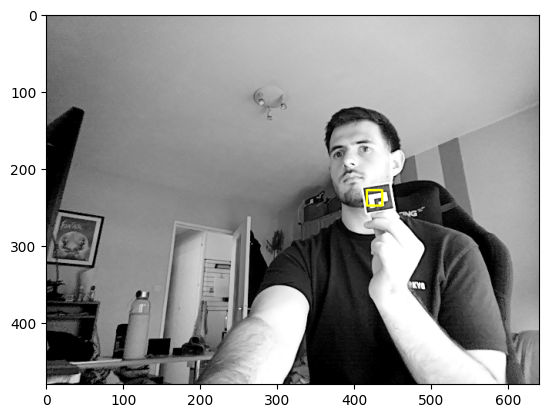

In [52]:
cv2.rectangle(
    frame_left,
    (int(p_coord_left[0]) - 10, int(p_coord_left[1]) - 10),
    (int(p_coord_left[0]) + 10, int(p_coord_left[1]) + 10),
    (0, 255, 255),
    2,
)

plt.imshow(cv2.cvtColor(frame_left, cv2.COLOR_BGR2RGB))

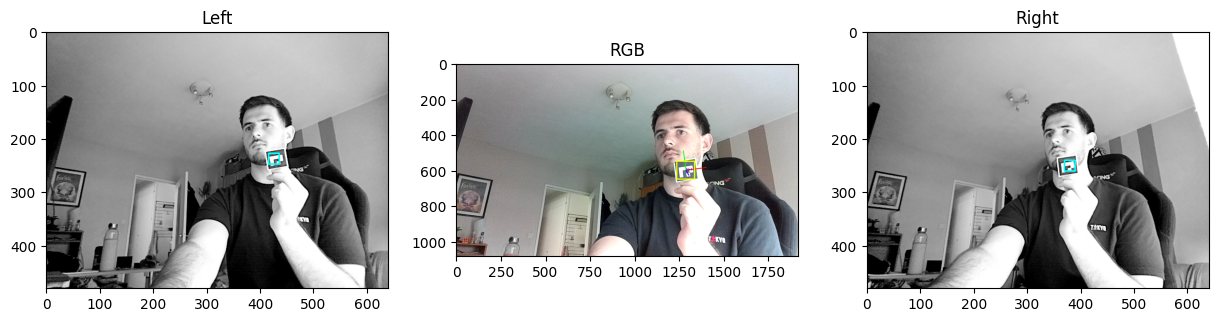

In [53]:
## Show the 3 images with the detected markers
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(frame_left)
plt.title("Left")
plt.subplot(132)
plt.imshow(cv2.cvtColor(frame_rgb, cv2.COLOR_BGR2RGB))
plt.title("RGB")
plt.subplot(133)
plt.imshow(frame_right)
plt.title("Right")
plt.show()